# Lectura y Análisis

In [134]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.metrics import mean_squared_error

# Missing values
from scipy.interpolate import PchipInterpolator

from sklearn.neighbors import NearestNeighbors

## Carga de datos

### Lectura de ficheros

Se leen los distintos fichero con la información meteorlógica.

Se establece una cota temporal a los datos de todos los ficheros.

In [135]:
dataframes = {}

def load(file, directory, start_date=None, end_date=None):
    file_path = directory + file + ".csv"
    print(f"Processing {file}...")
    
    try:
        df = pd.read_csv(file_path, parse_dates=['ts'], index_col='ts')
        df = df.sort_index()
        df_hourly = df.resample('h').mean()  # Resample by hour
        
        # Apply date filtering if start_date and end_date are provided
        if start_date and end_date:
            df_hourly = df_hourly.loc[start_date:end_date]
        print(df_hourly.iloc[0])
        print(df_hourly.iloc[-1])
        
        dataframes[file] = df_hourly
    except Exception as e:
        print(f"Error processing {file}: {e}")

In [136]:
# Read the CSV files
directory = "data/"

#########
# Dates #
#########
start_date = "2023-03-01"
end_date = "2025-02-28"

location = "punta_hidalgo"

grafcan = "grafcan_punta_hidalgo"
openmeteo_arpege = "openmeteo_punta_hidalgo_arpege"
openmeteo_icon = "openmeteo_punta_hidalgo_icon"

data_files = [grafcan,
              openmeteo_arpege,
              openmeteo_icon]
for file in data_files:
    load(file, directory, start_date, end_date)


Processing grafcan_punta_hidalgo...
air_temperature           18.213028
atmospheric_pressure    1020.134328
relative_humidity         89.022152
Name: 2023-03-01 00:00:00+00:00, dtype: float64
air_temperature           17.004394
atmospheric_pressure    1015.784180
relative_humidity         77.170876
Name: 2025-02-28 23:00:00+00:00, dtype: float64
Processing openmeteo_punta_hidalgo_arpege...
air_temperature           17.4
atmospheric_pressure    1018.1
relative_humidity         88.0
Name: 2023-03-01 00:00:00+00:00, dtype: float64
air_temperature           17.3
atmospheric_pressure    1013.2
relative_humidity         71.0
Name: 2025-02-28 23:00:00+00:00, dtype: float64
Processing openmeteo_punta_hidalgo_icon...
air_temperature           19.0
atmospheric_pressure    1018.1
relative_humidity         83.0
Name: 2023-03-01 00:00:00+00:00, dtype: float64
air_temperature           18.1
atmospheric_pressure    1013.3
relative_humidity         69.0
Name: 2025-02-28 23:00:00+00:00, dtype: float64


## Visualización

In [137]:
def plot_datasets_comparison(dataframes, column):
    """
    Plot a specific column from each dataset (given as a list of filenames)
    for all common years.
    
    Parameters:
        datasets (list): List of dataset filenames (e.g., ['file1.csv', 'file2.csv', ...]).
        column (str): The column name to plot from each dataset.
    """
    print ("Plotting " + column)
    
    df_names = dataframes.keys()
    dfs = dataframes.values()
    # Align all dataframes on their timestamps by concatenating on axis=1 (inner join ensures common timestamps)
    # Using keys creates a hierarchical column index: top level is dataset name, lower level is the original columns.
    combined = pd.concat(dfs, axis=1, join='inner', keys=df_names)
    
    # Ensure the indicated column exists in every dataset
    for name in df_names:
        if column not in combined[name].columns:
            print(f"Column '{column}' not found in dataset '{name}'.")
            return

    # Get all common years from the combined index
    common_years = combined.index.year.unique()
    
    # Plot the indicated column for each dataset by year
    for year in common_years:
        df_year = combined[combined.index.year == year]
        plt.figure(figsize=(10, 6))
        for name in df_names:
            plt.plot(df_year.index, df_year[name][column],
                     label=f"{name}", linestyle='-', alpha=0.7)
        plt.title(f'Comparison Plot - Column "{column}" - Year {year}')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()

### OpenMeteo

Plotting air_temperature


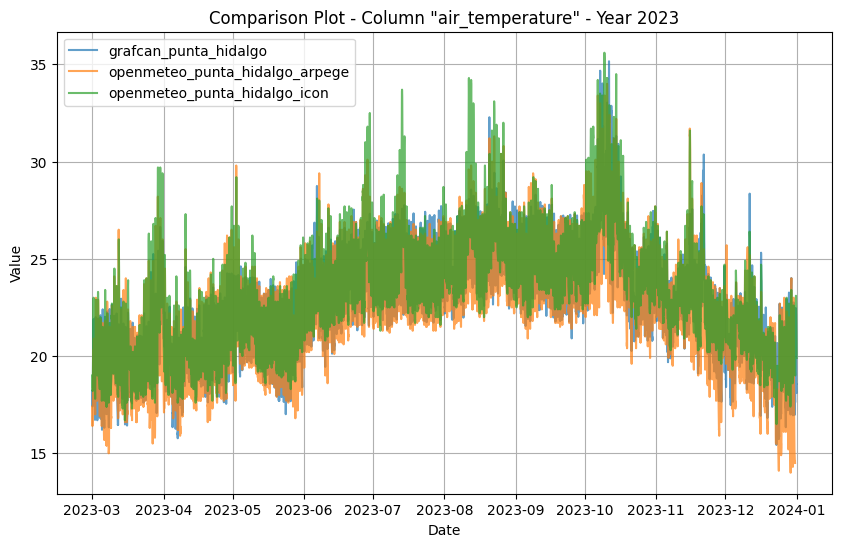

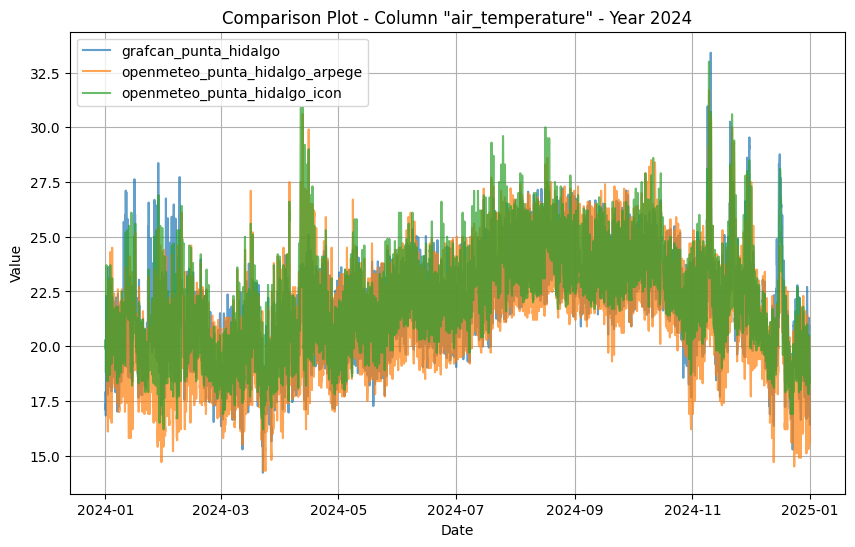

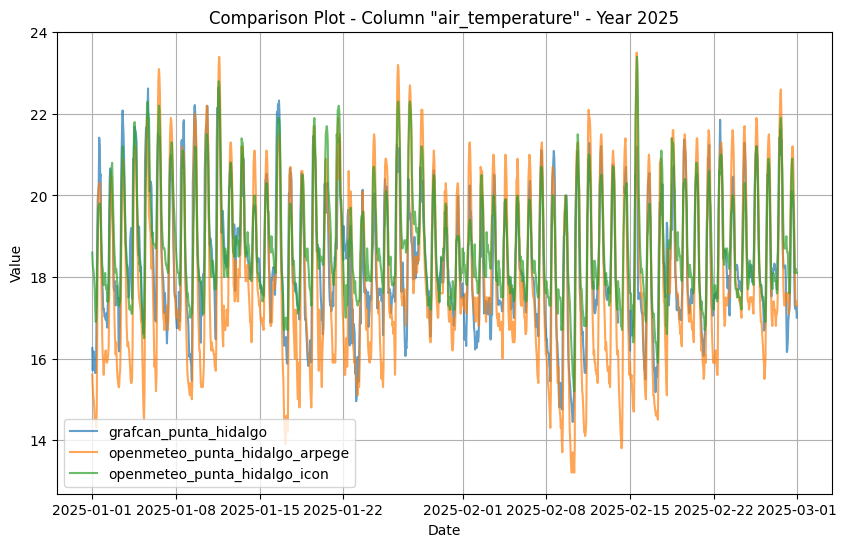

Plotting relative_humidity


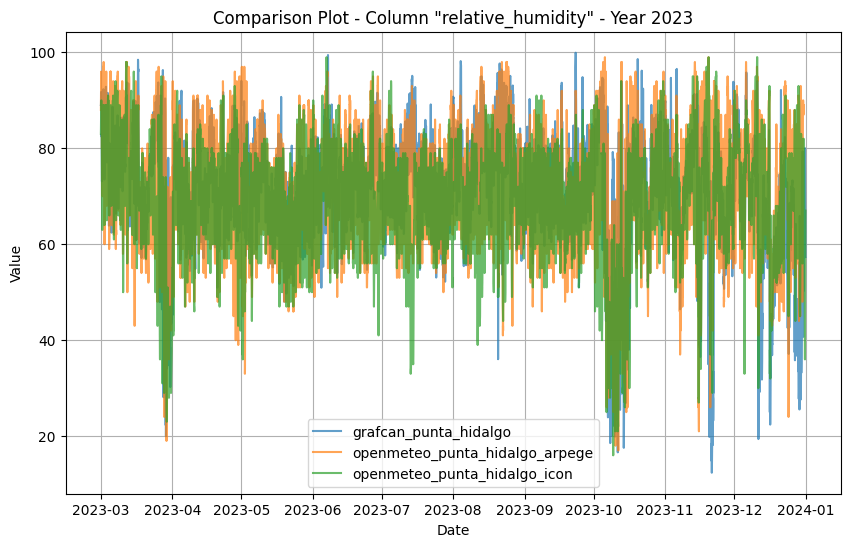

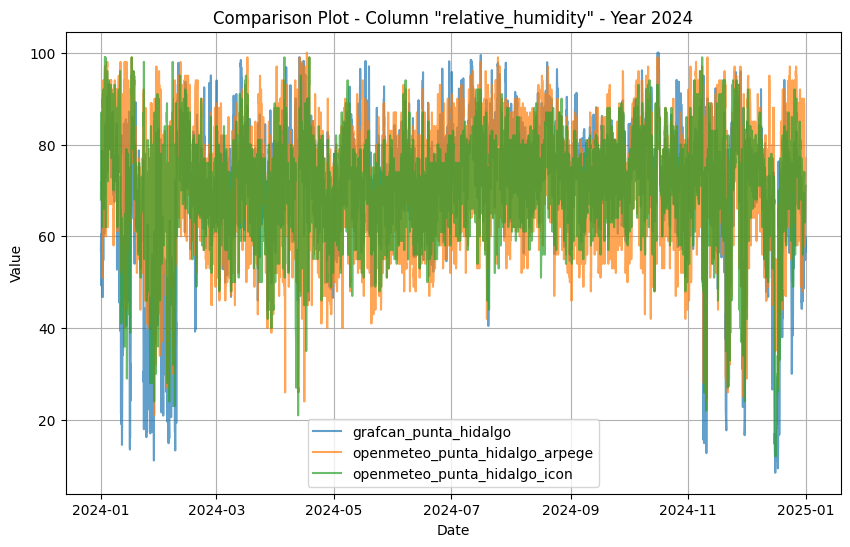

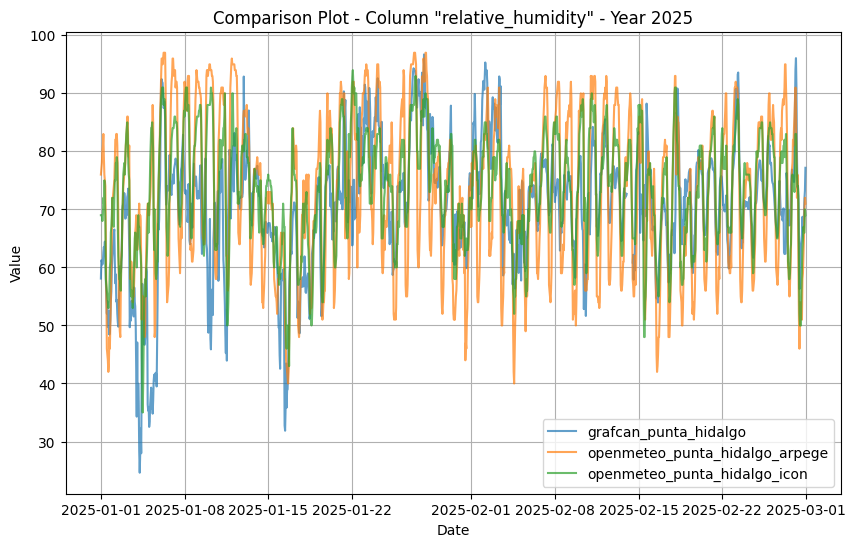

Plotting atmospheric_pressure


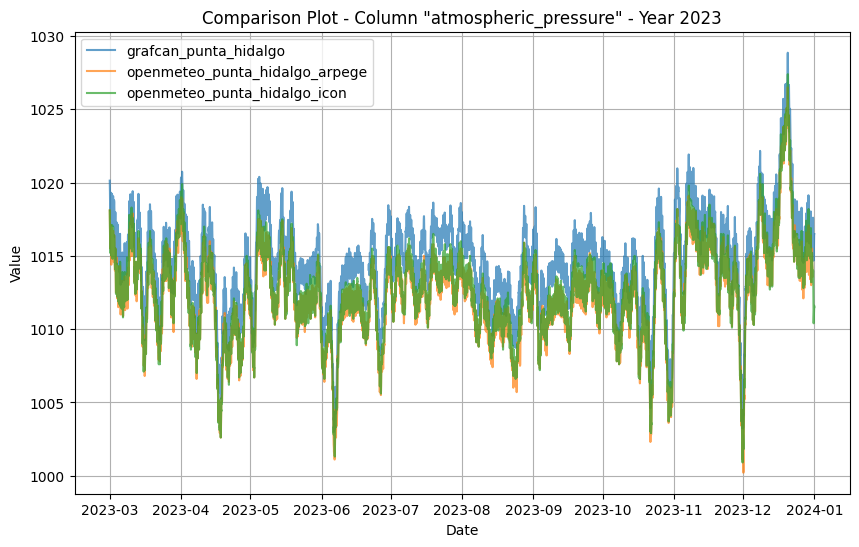

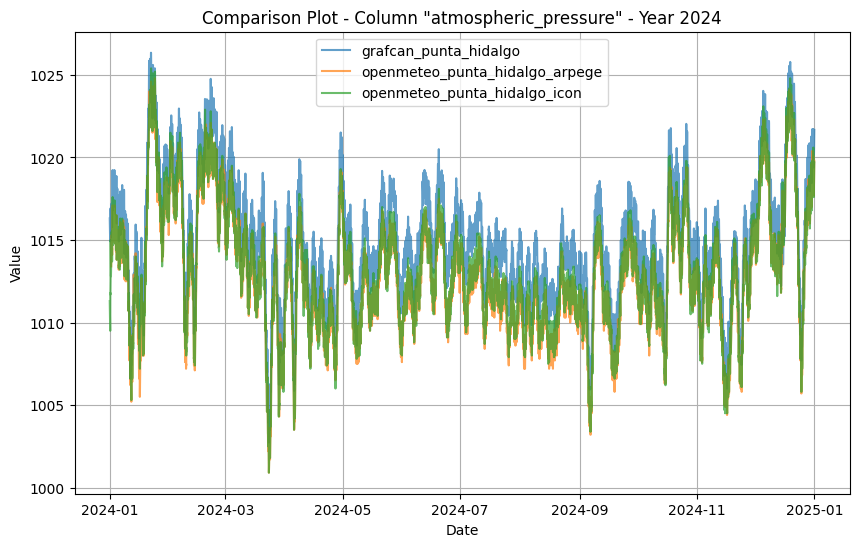

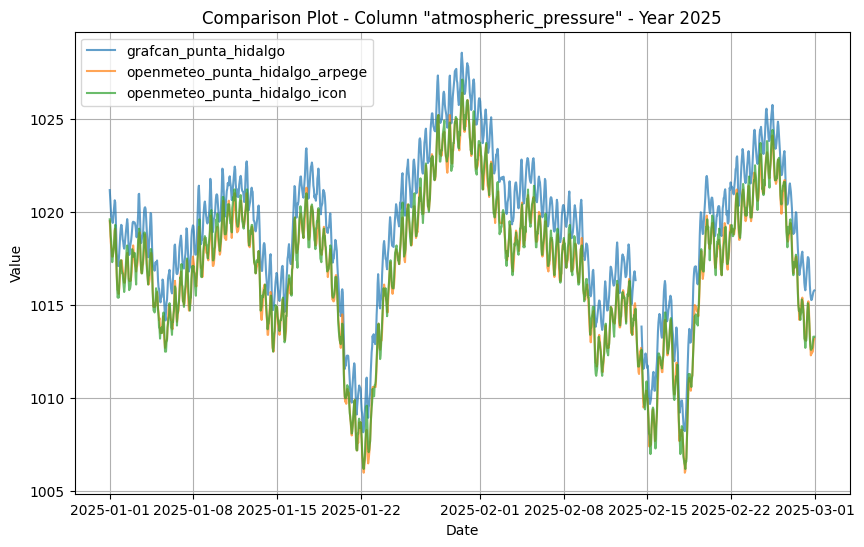

In [138]:
plot_datasets_comparison(dataframes, "air_temperature")
plot_datasets_comparison(dataframes, "relative_humidity")
plot_datasets_comparison(dataframes, "atmospheric_pressure")

## Horas faltantes

In [139]:
for file_key, df_hourly in dataframes.items():
    # Check for missing hours in the time series
    # Detect missing hours after resampling
    missing_hours = df_hourly[df_hourly.isna().any(axis=1)].index

    # Print missing hours if any
    if len(missing_hours) > 0:
        print(f"Missing hours in {file_key} after resampling:")
        print(missing_hours.tolist())
        print(len(missing_hours))
    else:
        print(f"No missing hours in {file_key} after resampling.")

Missing hours in grafcan_punta_hidalgo after resampling:
[Timestamp('2023-06-21 00:00:00+0000', tz='UTC'), Timestamp('2023-06-21 01:00:00+0000', tz='UTC'), Timestamp('2023-06-21 02:00:00+0000', tz='UTC'), Timestamp('2023-06-21 03:00:00+0000', tz='UTC'), Timestamp('2023-06-21 04:00:00+0000', tz='UTC'), Timestamp('2023-06-21 05:00:00+0000', tz='UTC'), Timestamp('2023-06-21 06:00:00+0000', tz='UTC'), Timestamp('2023-06-21 07:00:00+0000', tz='UTC'), Timestamp('2023-06-21 08:00:00+0000', tz='UTC'), Timestamp('2024-01-31 01:00:00+0000', tz='UTC'), Timestamp('2024-01-31 02:00:00+0000', tz='UTC'), Timestamp('2024-01-31 03:00:00+0000', tz='UTC'), Timestamp('2024-01-31 04:00:00+0000', tz='UTC'), Timestamp('2024-01-31 05:00:00+0000', tz='UTC'), Timestamp('2024-01-31 06:00:00+0000', tz='UTC'), Timestamp('2024-01-31 07:00:00+0000', tz='UTC'), Timestamp('2024-01-31 08:00:00+0000', tz='UTC'), Timestamp('2024-01-31 09:00:00+0000', tz='UTC'), Timestamp('2024-01-31 10:00:00+0000', tz='UTC'), Timestamp('

### Manejo Horas faltantes

In [140]:
# Use pchip interpolation if gap is small (less or equal to threshold hours) else, use previous day data
def missing_interpolation(df, interpolation_threshold=4):
    # Ensure index is datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("Index must be a DatetimeIndex.")

    # Convert datetime index to numeric for interpolation
    numeric_index = df.index.astype('int64') // 10**9

    # Initialize artificial_value_flag column with zeros if not present
    if "artificial_value_flag" not in df.columns:
        df["artificial_value_flag"] = 0

    for col in df.columns:
        if col == "artificial_value_flag":
            continue

        series = df[col].copy()
        is_nan = series.isna()
        nan_groups = (is_nan != is_nan.shift()).cumsum()
        nan_runs = is_nan.groupby(nan_groups).sum()
        nan_starts = is_nan.groupby(nan_groups).agg(lambda x: x.index[0])

        # Process each missing block
        for run_length, start_time in zip(nan_runs, nan_starts):
            if run_length == 0:
                continue

            end_time = start_time + pd.Timedelta(hours=run_length - 1)
            time_range = pd.date_range(start_time, end_time, freq="h")

            if run_length > interpolation_threshold:
                # Fill using previous day's same hours
                prev_day_range = time_range - pd.Timedelta(days=1)
                try:
                    fill_values = df.loc[prev_day_range, col].values
                    df.loc[time_range, col] = fill_values
                    df.loc[time_range, "artificial_value_flag"] = 1
                except KeyError:
                    print(f"Previous day data not available to fill gap starting {start_time}")
            else:
                # Will interpolate these later
                continue

        # Interpolate remaining missing values (<= threshold hours)
        remaining_nan = df[col].isna()
        valid_mask = ~remaining_nan

        if valid_mask.sum() >= 2:
            pchip = PchipInterpolator(numeric_index[valid_mask], df.loc[valid_mask, col])
            interpolated_values = pchip(numeric_index)
            df.loc[remaining_nan, col] = interpolated_values[remaining_nan]
            df.loc[remaining_nan, "artificial_value_flag"] = 1
        else:
            print(f"Not enough data points to interpolate column '{col}'.")

    return df

In [141]:
for file_key, df_hourly in dataframes.items():
    # Perform cubic spline interpolation on the dataframe
    missing_interpolation(df_hourly)

## Comparativa datasets openmeteo

In [142]:
def datasets_similarity(file1, file2):
    # Remove .csv extension if present
    file1 = file1.replace(".csv", "")
    file2 = file2.replace(".csv", "")
    
    # Ensure datasets are loaded
    if file1 not in dataframes or file2 not in dataframes:
        print("One or both datasets are not loaded.")
        return
    
    # Retrieve dataframes and align by timestamp
    df1 = dataframes[file1].drop(columns=["artificial_value_flag"])
    df2 = dataframes[file2].drop(columns=["artificial_value_flag"])
    df1, df2 = df1.align(df2, join='inner')
    
    similarity_results = {}
    for column in df1.columns:
        if column in df2.columns:
            try:
                pearson_corr, _ = pearsonr(df1[column], df2[column])
                spearman_corr, _ = spearmanr(df1[column], df2[column])
                kendall_corr, _ = kendalltau(df1[column], df2[column])
                mse = mean_squared_error(df1[column], df2[column])
                euclid_dist = euclidean(df1[column], df2[column])
                
                similarity_results[column] = {
                    "Pearson": pearson_corr,
                    "Spearman": spearman_corr,
                    "Kendall": kendall_corr,
                    "MSE": mse,
                    "Euclidean Distance": euclid_dist
                }
            except Exception as e:
                print(f"Error calculating similarity for {column}: {e}")
    
    print(f"Similarity Metrics for {file1} vs {file2}")
    for col, metrics in similarity_results.items():
        print(f"  {col}:")
        for metric, value in metrics.items():
            print(f"    {metric}: {value:.4f}")


In [143]:
datasets_similarity(openmeteo_icon, grafcan)

Similarity Metrics for openmeteo_punta_hidalgo_icon vs grafcan_punta_hidalgo
  air_temperature:
    Pearson: 0.9150
    Spearman: 0.9303
    Kendall: 0.7797
    MSE: 1.7220
    Euclidean Distance: 173.8128
  atmospheric_pressure:
    Pearson: 0.9874
    Spearman: 0.9834
    Kendall: 0.9009
    MSE: 4.6554
    Euclidean Distance: 285.7857
  relative_humidity:
    Pearson: 0.5109
    Spearman: 0.5545
    Kendall: 0.4081
    MSE: 157.2469
    Euclidean Distance: 1660.9452


In [144]:
datasets_similarity(openmeteo_arpege, grafcan)

Similarity Metrics for openmeteo_punta_hidalgo_arpege vs grafcan_punta_hidalgo
  air_temperature:
    Pearson: 0.9167
    Spearman: 0.9274
    Kendall: 0.7811
    MSE: 1.6610
    Euclidean Distance: 170.7043
  atmospheric_pressure:
    Pearson: 0.9894
    Spearman: 0.9860
    Kendall: 0.9084
    MSE: 5.6888
    Euclidean Distance: 315.9185
  relative_humidity:
    Pearson: 0.5171
    Spearman: 0.5929
    Kendall: 0.4392
    MSE: 172.7767
    Euclidean Distance: 1741.0324


### Selección de datasets

In [145]:
ned_df_openmeteo = "openmeteo_" + location
dataframes[ned_df_openmeteo] = dataframes[openmeteo_arpege].copy()

# Erase individual dataframes
del dataframes[openmeteo_icon]
del dataframes[openmeteo_arpege]

## Detección de outliers



### Análisis IQR

In [146]:
def detect_outliers_iqr(df, columns, threshold=1.5, return_indices=False):
    """
    Detects and plots outliers in each numerical column of a Pandas DataFrame using the Interquartile Range (IQR) method.
    Optionally returns indices of the detected outliers.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        threshold (float): The multiplier for the IQR to determine outlier boundaries.
        return_indices (bool): If True, also return a dictionary of outlier indices for each column.
        
    Returns:
        outliers_dict (dict): A dictionary containing outlier values for each numerical column.
        outlier_indices_dict (dict, optional): A dictionary containing outlier row indices for each numerical column.
    """
    outliers_dict = {}
    outlier_indices_dict = {}
    
    for column in df[columns].columns:
        # Calculate IQR-based bounds
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        # Identify outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
        outliers_dict[column] = outliers.tolist()
        outlier_indices_dict[column] = outliers.index.tolist()
        
        # Create subplots for boxplot and histogram
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
        
        # Boxplot on the left with outliers highlighted
        ax1.boxplot(df[column], vert=False)
        ax1.scatter(outliers, [1] * len(outliers), color='red', label='Outliers')
        ax1.set_title(f'Boxplot of {column}')  # Fixed typo here
        ax1.set_xlabel(column)
        ax1.legend()
        
        # Histogram on the right with bounds indicated
        ax2.hist(df[column], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
        ax2.axvline(lower_bound, color='red', linestyle='dashed', linewidth=1, label='Lower bound')
        ax2.axvline(upper_bound, color='red', linestyle='dashed', linewidth=1, label='Upper bound')
        ax2.set_title(f'Histogram of {column}')
        ax2.set_xlabel(column)
        ax2.set_ylabel('Frequency')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
    
    if return_indices:
        return outliers_dict, outlier_indices_dict
    return outliers_dict


Processing grafcan_punta_hidalgo:


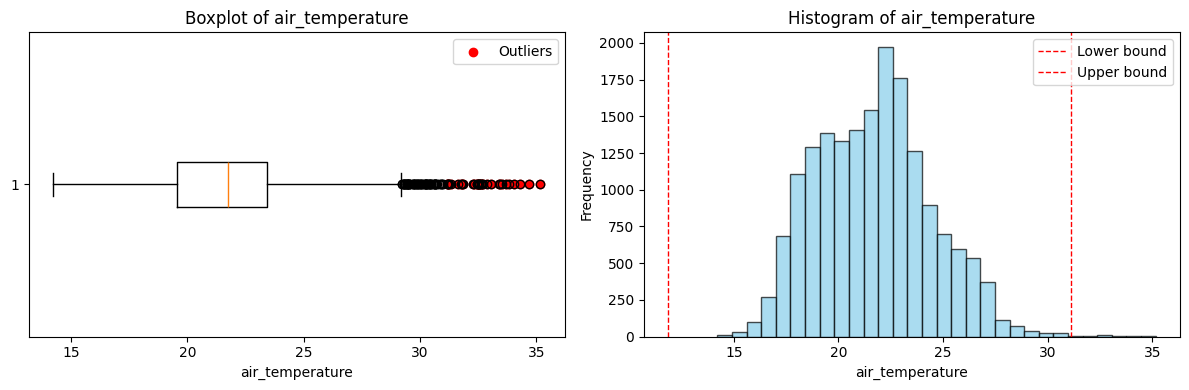

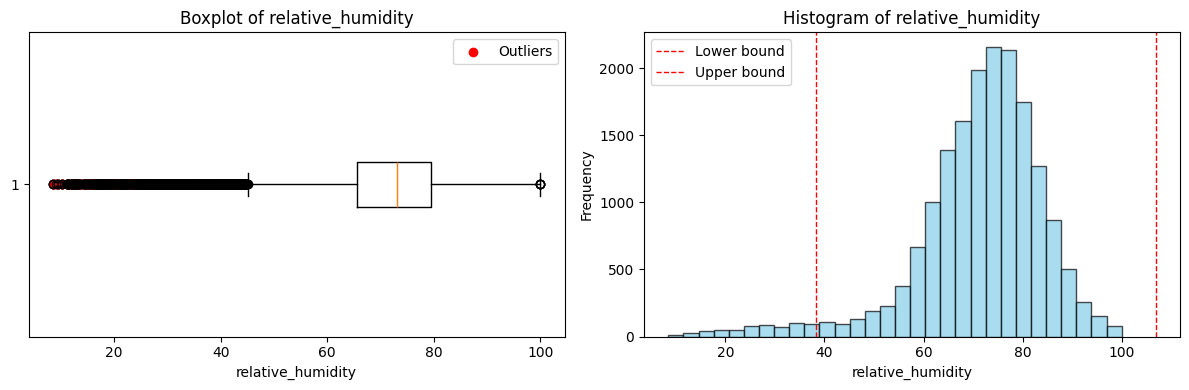

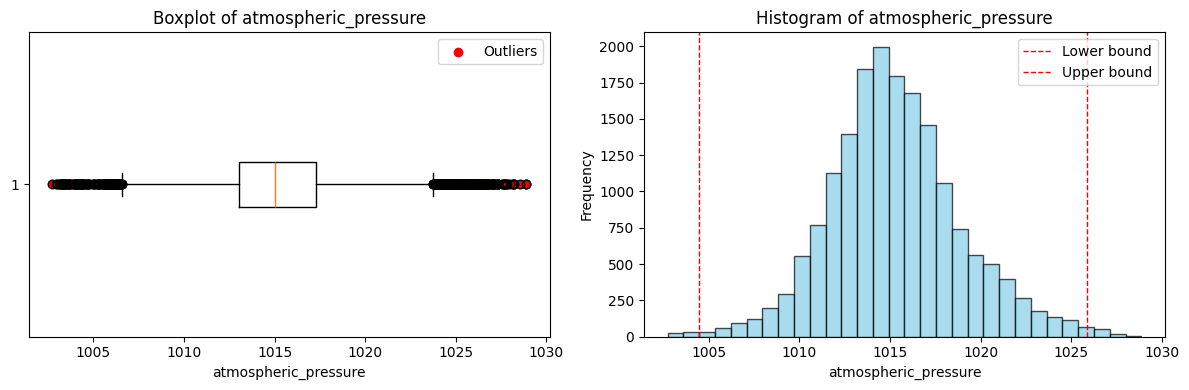

  air_temperature outlier row indices: [Timestamp('2023-08-20 11:00:00+0000', tz='UTC'), Timestamp('2023-08-20 12:00:00+0000', tz='UTC'), Timestamp('2023-10-06 15:00:00+0000', tz='UTC'), Timestamp('2023-10-07 13:00:00+0000', tz='UTC'), Timestamp('2023-10-07 14:00:00+0000', tz='UTC'), Timestamp('2023-10-07 15:00:00+0000', tz='UTC'), Timestamp('2023-10-07 16:00:00+0000', tz='UTC'), Timestamp('2023-10-08 05:00:00+0000', tz='UTC'), Timestamp('2023-10-08 11:00:00+0000', tz='UTC'), Timestamp('2023-10-08 12:00:00+0000', tz='UTC'), Timestamp('2023-10-08 13:00:00+0000', tz='UTC'), Timestamp('2023-10-08 14:00:00+0000', tz='UTC'), Timestamp('2023-10-08 15:00:00+0000', tz='UTC'), Timestamp('2023-10-08 16:00:00+0000', tz='UTC'), Timestamp('2023-10-08 21:00:00+0000', tz='UTC'), Timestamp('2023-10-08 22:00:00+0000', tz='UTC'), Timestamp('2023-10-10 14:00:00+0000', tz='UTC'), Timestamp('2023-10-10 15:00:00+0000', tz='UTC'), Timestamp('2023-10-10 16:00:00+0000', tz='UTC'), Timestamp('2023-10-10 17:00:0

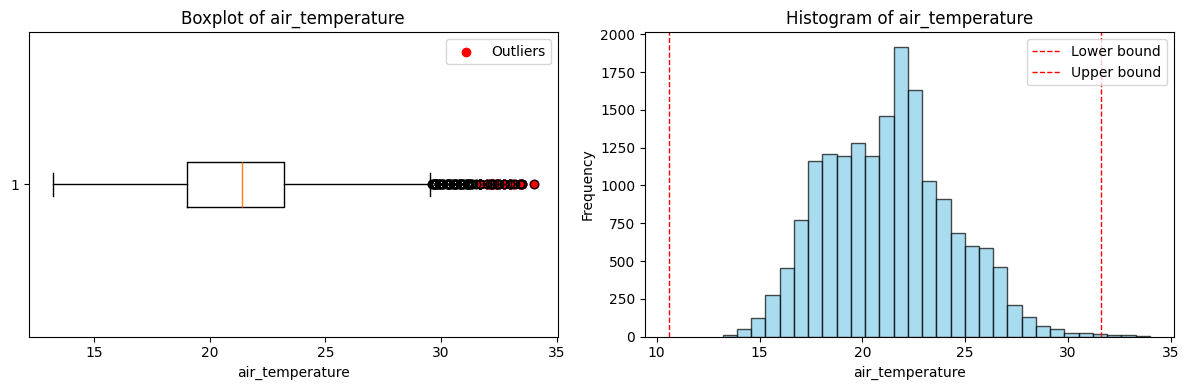

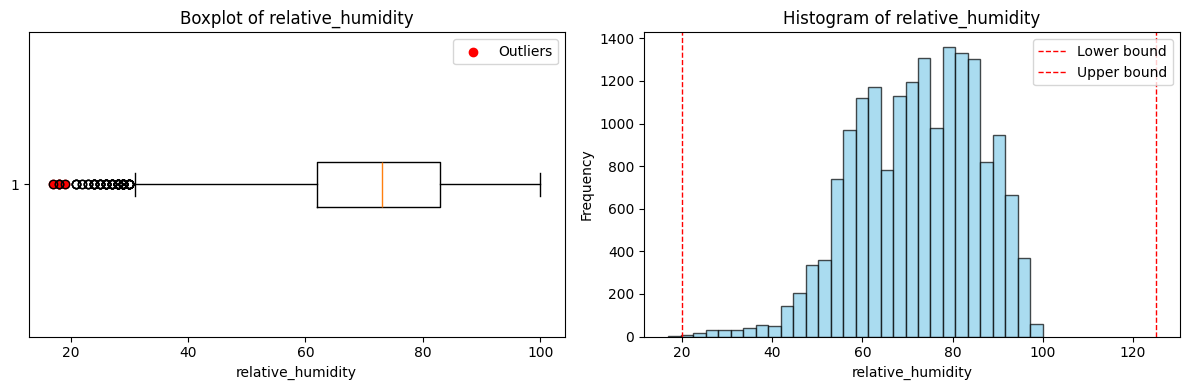

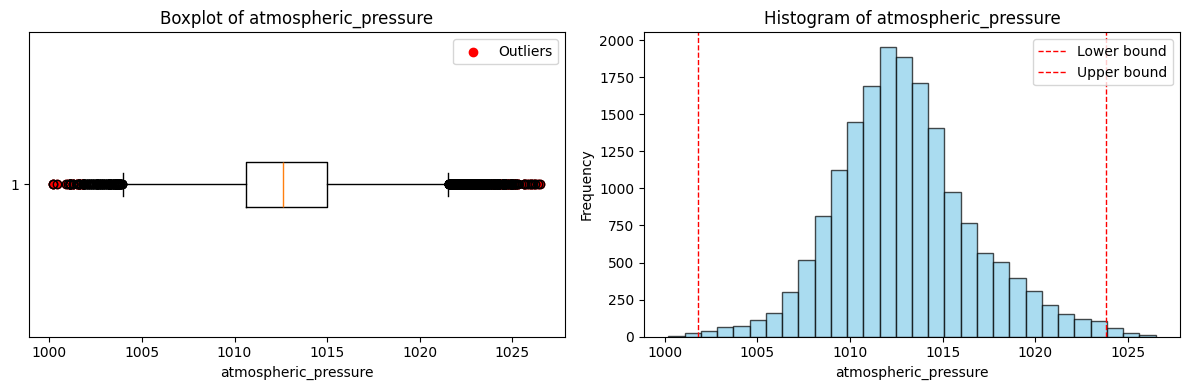

  air_temperature outlier row indices: [Timestamp('2023-10-06 13:00:00+0000', tz='UTC'), Timestamp('2023-10-06 14:00:00+0000', tz='UTC'), Timestamp('2023-10-06 15:00:00+0000', tz='UTC'), Timestamp('2023-10-06 16:00:00+0000', tz='UTC'), Timestamp('2023-10-07 12:00:00+0000', tz='UTC'), Timestamp('2023-10-07 13:00:00+0000', tz='UTC'), Timestamp('2023-10-07 14:00:00+0000', tz='UTC'), Timestamp('2023-10-07 15:00:00+0000', tz='UTC'), Timestamp('2023-10-07 16:00:00+0000', tz='UTC'), Timestamp('2023-10-08 13:00:00+0000', tz='UTC'), Timestamp('2023-10-09 13:00:00+0000', tz='UTC'), Timestamp('2023-10-09 14:00:00+0000', tz='UTC'), Timestamp('2023-10-09 15:00:00+0000', tz='UTC'), Timestamp('2023-10-09 16:00:00+0000', tz='UTC'), Timestamp('2023-10-10 11:00:00+0000', tz='UTC'), Timestamp('2023-10-10 12:00:00+0000', tz='UTC'), Timestamp('2023-10-10 13:00:00+0000', tz='UTC'), Timestamp('2023-10-10 14:00:00+0000', tz='UTC'), Timestamp('2023-10-10 15:00:00+0000', tz='UTC'), Timestamp('2023-10-10 16:00:0

In [147]:
threshold = 2
columns = ["air_temperature", "relative_humidity", "atmospheric_pressure"]

for file_key, df_hourly in dataframes.items():
    print(f"Processing {file_key}:")
    
    # Use the modified function to get both outlier values and their indices
    outliers, outlier_indices = detect_outliers_iqr(df_hourly, columns, threshold, return_indices=True)
    
    # Print outliers for each column
    for column, indices in outlier_indices.items():
        print(f"  {column} outlier row indices: {indices}")
    
    # Combine all outlier indices from every column
    all_outlier_indices = set()
    for indices in outlier_indices.values():
        all_outlier_indices.update(indices)
    
    # Remove rows with any detected outlier
    # df_clean = df_hourly.drop(list(all_outlier_indices))
    # dataframes[file_key] = df_clean
    
    print(f"Detected {len(all_outlier_indices)} rows with outliers from {file_key}.\n")

### KNN

Processing grafcan_punta_hidalgo for KNN outlier detection...
air_temperature


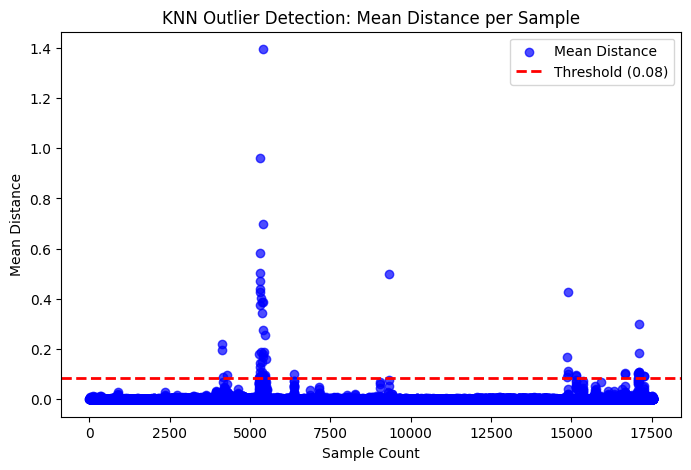

Detected 63 outliers at indices: [ 4139  4140  4144  4287  5269  5271  5272  5294  5295  5296  5297  5308
  5315  5316  5317  5318  5319  5320  5325  5326  5342  5359  5361  5366
  5367  5368  5369  5385  5386  5387  5388  5389  5410  5411  5413  5435
  5440  5462  5463  5464  5483  6374  9309 14853 14863 14891 14892 14893
 15135 15136 16658 16659 17065 17070 17072 17089 17090 17092 17093 17094
 17095 17259 17260]
atmospheric_pressure


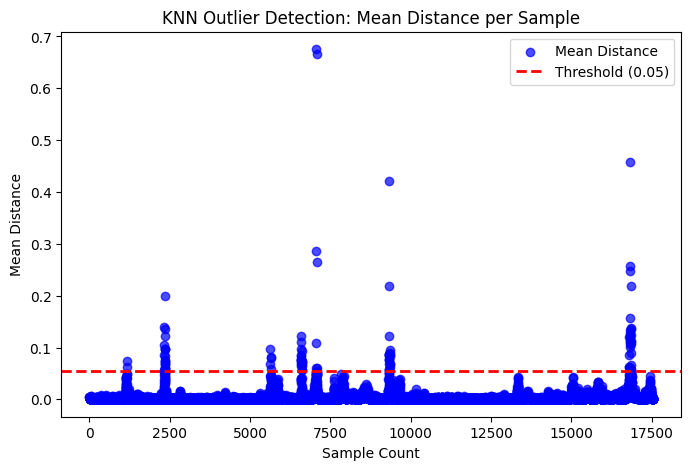

Detected 107 outliers at indices: [ 1155  1157  2330  2332  2333  2334  2336  2337  2338  2340  2342  2343
  2344  2345  2346  2348  2349  2355  2356  2357  2359  2360  2361  5633
  5634  5635  5636  5643  6581  6582  6584  6590  6591  6592  6593  6594
  6596  6597  6598  6599  6600  6601  6602  6603  6604  6605  6606  6607
  7041  7064  7065  7066  7067  7068  7071  7075  9316  9317  9318  9319
  9321  9323  9324  9325  9326  9327  9328  9329  9330  9337  9338  9339
  9340  9341  9342  9343  9344  9345 16785 16786 16787 16788 16810 16811
 16817 16820 16821 16822 16823 16824 16826 16833 16834 16835 16836 16837
 16838 16843 16844 16845 16846 16847 16848 16849 16852 16859 16860]
relative_humidity


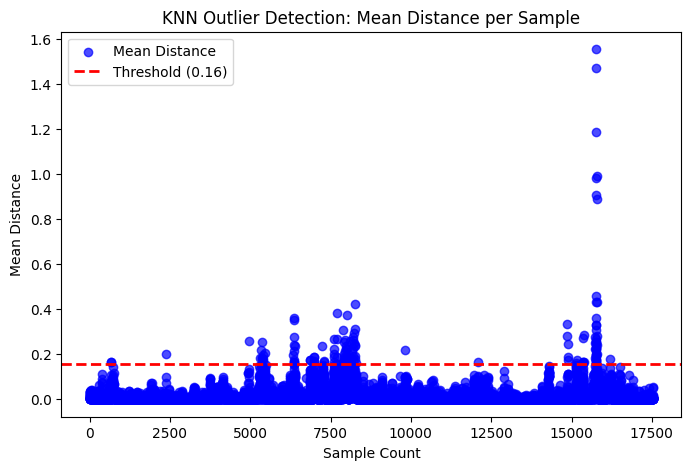

Detected 138 outliers at indices: [  678   679  2367  4947  5309  5326  5359  5377  5378  5387  5407  5413
  5453  6342  6361  6362  6363  6365  6366  6367  6368  6370  6371  6372
  6382  6853  6862  6970  6972  6978  6991  7231  7293  7296  7599  7600
  7601  7605  7607  7705  7706  7708  7714  7885  7888  7903  7908  7910
  7912  7915  7916  7918  7942  7945  7946  7956  7962  7966  7967  7980
  7994  8000  8004  8005  8021  8093  8098  8099  8123  8172  8187  8188
  8193  8196  8197  8220  8240  8252  8262  8264  8269  8270  8271  8284
  9819 12080 14853 14863 14884 14891 14892 15137 15169 15347 15359 15369
 15372 15373 15374 15741 15742 15745 15746 15747 15748 15749 15750 15751
 15752 15753 15754 15755 15756 15757 15758 15759 15760 15761 15762 15763
 15764 15765 15766 15767 15768 15769 15770 15771 15772 15773 15774 15779
 15783 15784 15785 15786 15787 16208]
Processing openmeteo_punta_hidalgo for KNN outlier detection...
air_temperature


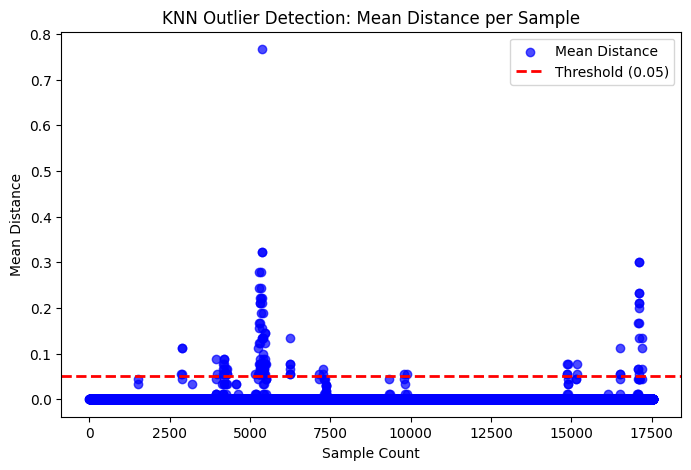

Detected 115 outliers at indices: [ 2848  2869  2870  2871  3925  3974  4141  4142  4170  4188  4189  4190
  4191  4192  4261  4286  4288  4289  5151  5246  5247  5268  5269  5270
  5271  5272  5273  5291  5292  5293  5294  5295  5296  5297  5298  5315
  5316  5317  5318  5319  5320  5321  5340  5341  5342  5343  5344  5345
  5346  5362  5363  5364  5365  5366  5367  5368  5369  5370  5371  5388
  5389  5390  5391  5392  5393  5394  5416  5437  5438  5439  5440  5459
  5460  5461  5462  5463  5464  5465  5487  6228  6229  6230  6231  6232
  6233  7157  7279  7280  9805  9880 14870 14871 14872 14894 15159 15183
 16515 16516 16517 17071 17072 17088 17089 17090 17091 17092 17093 17094
 17095 17096 17097 17118 17190 17191 17192]
atmospheric_pressure


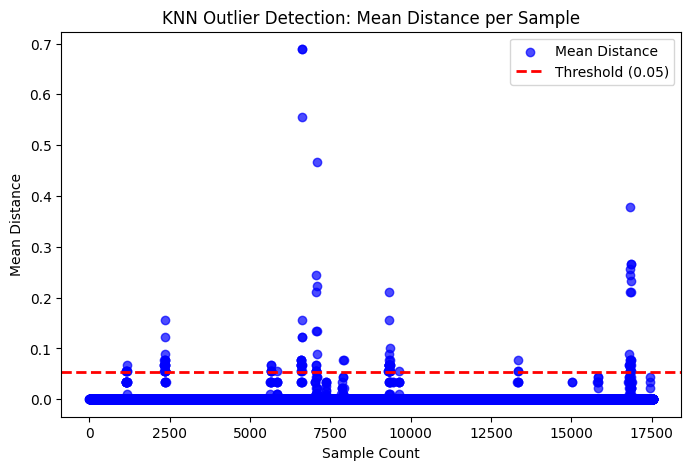

Detected 129 outliers at indices: [ 1137  1146  1147  1154  1155  1158  2331  2332  2333  2334  2335  2336
  2337  2338  2339  2340  2341  2342  2343  2344  2345  2346  2347  2348
  2349  2354  2356  2366  5635  5640  5641  5642  5643  5644  5846  6584
  6585  6591  6592  6593  6594  6595  6596  6597  6598  6599  6600  6601
  6602  6603  6604  6605  6606  6607  6608  7054  7055  7056  7057  7058
  7059  7063  7064  7065  7066  7067  7068  7069  7070  7906  7907  9303
  9304  9316  9317  9318  9319  9320  9321  9322  9324  9325  9326  9327
  9328  9329  9330  9331  9332  9333  9336  9337  9338  9339  9340  9341
  9342  9343  9344  9345  9351  9638 13328 13336 13339 16787 16788 16789
 16811 16821 16822 16823 16824 16825 16833 16834 16835 16836 16837 16838
 16844 16845 16846 16847 16848 16849 16850 16859 16860]
relative_humidity


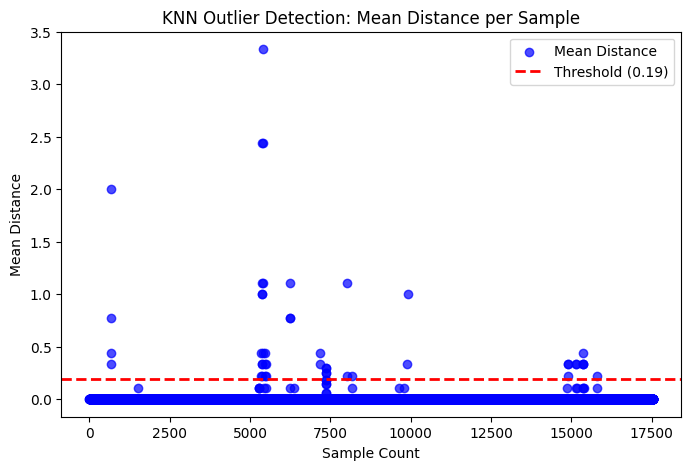

Detected 46 outliers at indices: [  660   661   684   685  5341  5342  5362  5363  5364  5365  5366  5367
  5368  5390  5391  5392  5393  5459  5463  5476  5486  5488  6231  6232
  6233  7167  7168  7351  7355  7357  7361  8008  8009  8174  9880  9912
 14887 14896 14897 15134 15156 15348 15351 15352 15370 15792]


In [148]:
def knn_outlier_detection(data, k=10, threshold=4):
    """
    Detect outliers using K-Nearest Neighbors.
    
    Parameters:
    - data: 1D numpy array of values.
    - k: Number of neighbors to consider.
    - threshold: Multiplier for the mean distance to determine outliers.
    
    Returns:
    - outliers: Indices of detected outliers.
    """
    data = data.reshape(-1, 1)  # Reshape for sklearn compatibility
    
    nbrs = NearestNeighbors(n_neighbors=k)
    nbrs.fit(data)
    distances, _ = nbrs.kneighbors(data)
    
    mean_distances = distances[:, 1:].mean(axis=1)  # Ignore self-distance (0)
    
    threshold_value = mean_distances.mean() + threshold * mean_distances.std()
    outliers = np.where(mean_distances > threshold_value)[0]
    
    # Plot distance distribution with better bin scaling
    plt.figure(figsize=(8, 5))
    plt.scatter(np.arange(len(mean_distances)), mean_distances, color='b', alpha=0.7, label='Mean Distance')
    plt.axhline(threshold_value, color='r', linestyle='dashed', linewidth=2,
                label=f'Threshold ({threshold_value:.2f})')
    #plt.yscale('log')  # Log scale for y-axis
    plt.xlabel('Sample Count')
    plt.ylabel('Mean Distance')
    plt.title('KNN Outlier Detection: Mean Distance per Sample')
    plt.legend()
    plt.show()
    
    print(f"Detected {len(outliers)} outliers at indices: {outliers}")
    
    return outliers

for name, df in dataframes.items(): 
    print(f"Processing {name} for KNN outlier detection...")
    
    # Flag outliers initialized at 0
    flag = np.zeros(len(df), dtype=int)

    print("air_temperature")
    data = df["air_temperature"].values
    outliers = knn_outlier_detection(data)
    flag[outliers] = 1

    print("atmospheric_pressure")
    data = df["atmospheric_pressure"].values
    outliers = knn_outlier_detection(data)
    flag[outliers] = 1
    
    print("relative_humidity")
    data = df["relative_humidity"].values
    outliers = knn_outlier_detection(data)
    flag[outliers] = 1

    # Assign this flag array as a new column
    df["outlier_flag"] = flag

Plotting histogram for grafcan_punta_hidalgo...


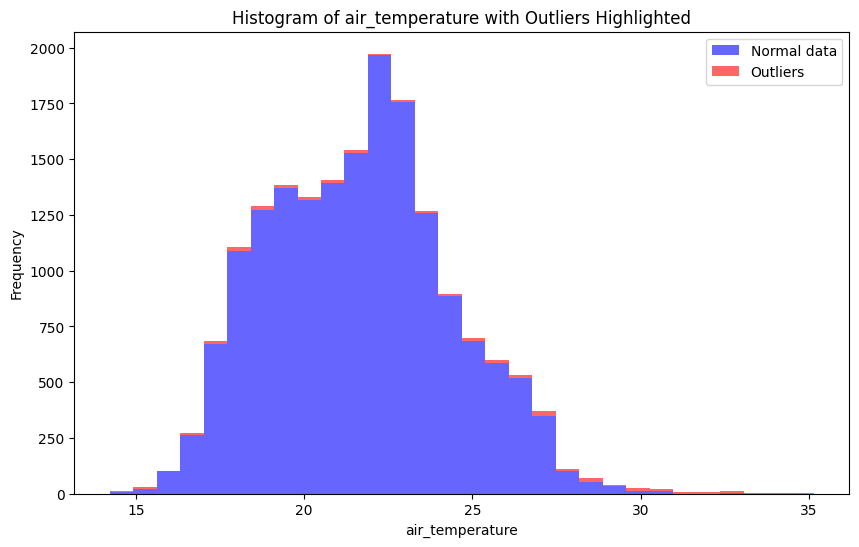

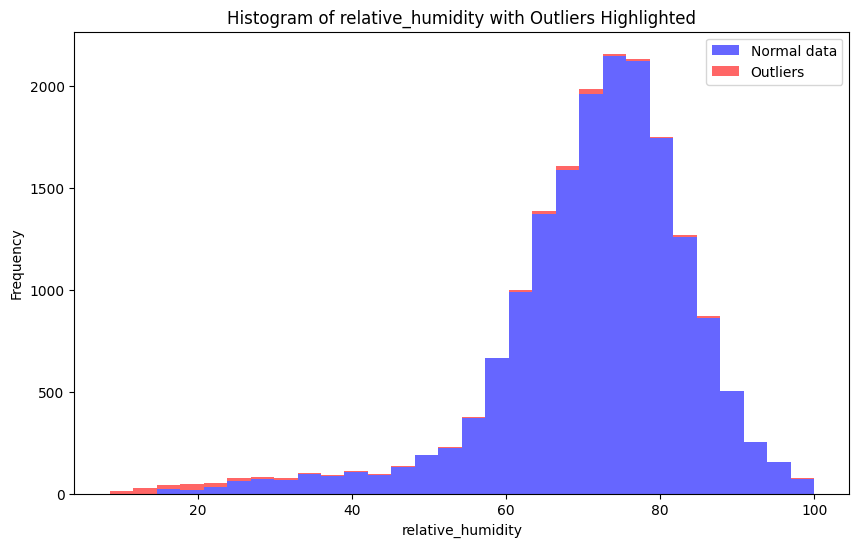

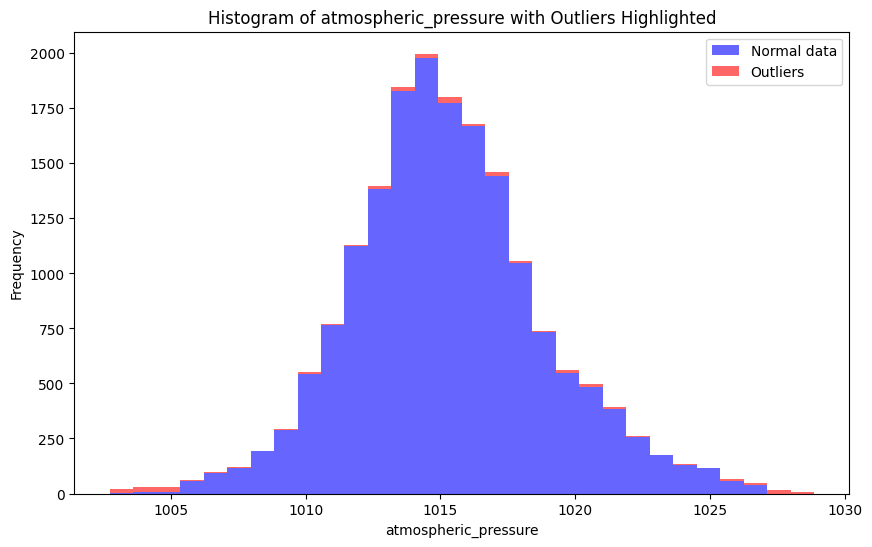

Plotting histogram for openmeteo_punta_hidalgo...


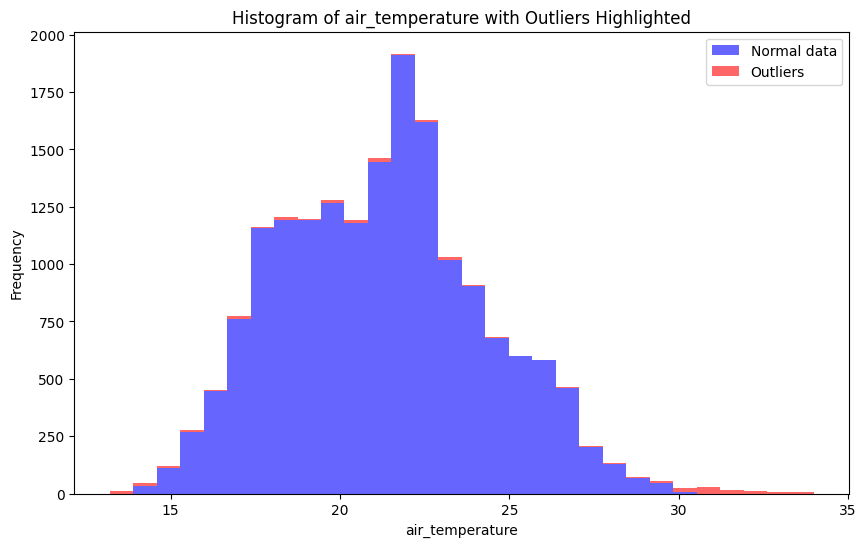

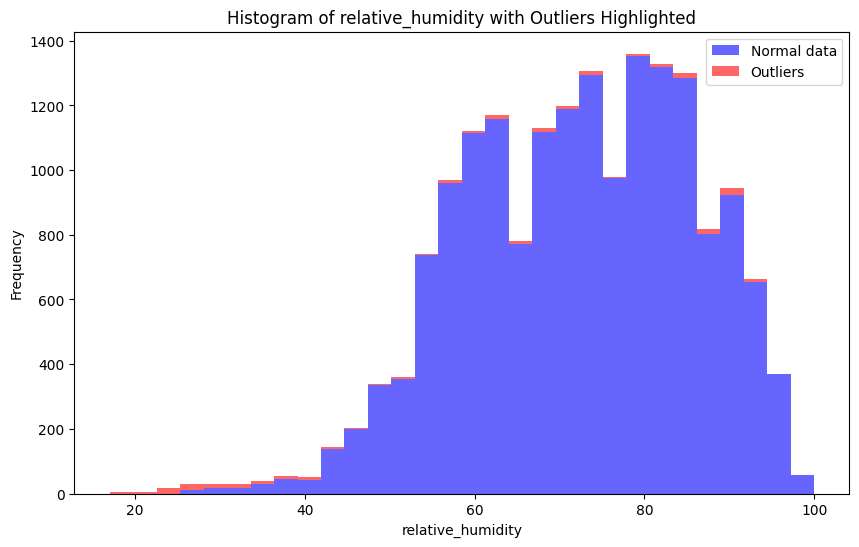

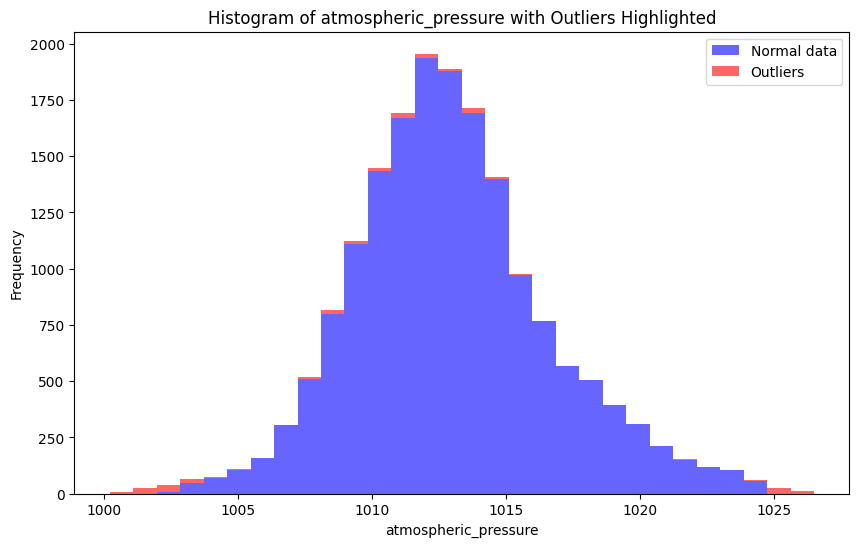

In [149]:
def plot_histogram_with_outliers(df, column, outlier_flag_column='outlier_flag', bins=30):
    """
    Plots a histogram for a specified column in the DataFrame, highlighting outliers.
    
    Parameters:
    - df: DataFrame containing the data.
    - column: Column name (string) for which to plot the histogram.
    - outlier_flag_column: Column name (string) containing the outlier flags (default 'outlier_flag').
    - bins: Number of bins for the histogram (default 30).
    """
    plt.figure(figsize=(10, 6))
    

    # Define bin edges based on the full dataset
    bin_edges = np.histogram_bin_edges(df[column], bins=bins)
    
    # Plot normal data histogram
    plt.hist([df.loc[df[outlier_flag_column] == 0, column], df.loc[df[outlier_flag_column] == 1, column]], stacked=True, bins=bin_edges, 
             color=['blue', 'red'], alpha=0.6, label=['Normal data', 'Outliers'])
    
    plt.xlabel(column)
    plt.ylabel("Frequency")
    #plt.yscale('log')  # Log scale for y-axis
    plt.title(f"Histogram of {column} with Outliers Highlighted")
    plt.legend()
    plt.show()

# Example usage:
for df_key in dataframes.keys():
    print(f"Plotting histogram for {df_key}...")
    plot_histogram_with_outliers(dataframes[df_key], "air_temperature")
    plot_histogram_with_outliers(dataframes[df_key], "relative_humidity")
    plot_histogram_with_outliers(dataframes[df_key], "atmospheric_pressure")

## Exploración frecuencias - Fourier

In [150]:
def plot_frequencies(df, column, freq_min, freq_max, top_n=3, sampling_interval=3600):
    values = df[column].values  # Extraer la columna de valores
    
    fft_result = np.fft.fft(values)  # Calcular la FFT
    frequencies = np.fft.fftfreq(len(values), d=sampling_interval)  # Calcular las frecuencias
    
    # Solo conservar las frecuencias positivas
    positive_frequencies = frequencies[:len(values) // 2]
    positive_fft_result = fft_result[:len(values) // 2]
    magnitude = np.abs(positive_fft_result)
    
    # Filtrar las frecuencias dentro del rango deseado
    mask = (positive_frequencies >= freq_min) & (positive_frequencies <= freq_max)
    filtered_frequencies = positive_frequencies[mask]
    filtered_magnitude = magnitude[mask]
    
    # Encontrar los índices de las N frecuencias con mayor magnitud
    top_indices = np.argsort(filtered_magnitude)[-top_n:]
    
    # Imprimir las N frecuencias principales
    print(f"Top {top_n} frequencies with highest magnitude:")
    for idx in top_indices:
        frequency_hz = filtered_frequencies[idx]
        period_hours = 1 / (frequency_hz * 3600)
        print(f"Frequency: {frequency_hz:.8f} Hz, Period: {period_hours:.2f} hours, Magnitude: {filtered_magnitude[idx]:.4f}")
    
    # Graficar el espectro de frecuencia con escala logarítmica en el eje X
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_frequencies, filtered_magnitude, label='Frequency Spectrum')
    
    # Resaltar las N frecuencias principales
    top_frequencies = filtered_frequencies[top_indices]
    top_magnitudes = filtered_magnitude[top_indices]
    plt.scatter(top_frequencies, top_magnitudes, color='red', zorder=5, label=f'Top {top_n} Frequencies')
    
    # Configurar escala logarítmica para el eje X
    plt.xscale('log')
    plt.xlabel('Frequency (Hz, log scale)')
    plt.ylabel('Magnitude')
    plt.title(f'{column}: Frequency Spectrum between {freq_min} Hz and {freq_max} Hz')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Plotting frequencies for grafcan_punta_hidalgo...
Top 5 frequencies with highest magnitude:
Frequency: 0.00000011 Hz, Period: 2506.29 hours, Magnitude: 4938.5066
Frequency: 0.00002315 Hz, Period: 12.00 hours, Magnitude: 5484.3125
Frequency: 0.00000002 Hz, Period: 17544.00 hours, Magnitude: 6118.9813
Frequency: 0.00001157 Hz, Period: 24.00 hours, Magnitude: 16641.7108
Frequency: 0.00000003 Hz, Period: 8772.00 hours, Magnitude: 23105.2643


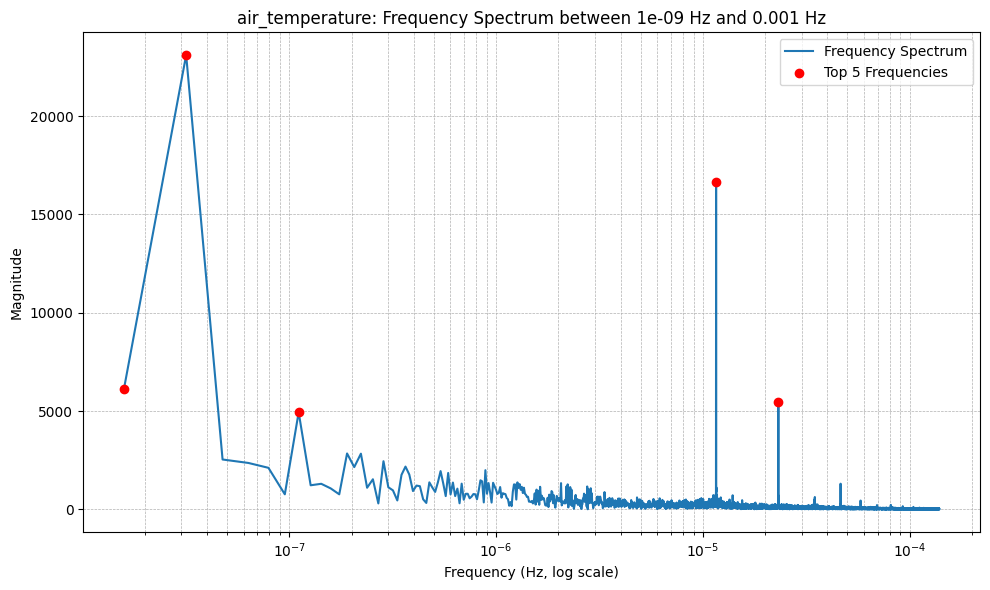

Top 5 frequencies with highest magnitude:
Frequency: 0.00000024 Hz, Period: 1169.60 hours, Magnitude: 21069.0006
Frequency: 0.00000002 Hz, Period: 17544.00 hours, Magnitude: 21434.2966
Frequency: 0.00000006 Hz, Period: 4386.00 hours, Magnitude: 26787.5546
Frequency: 0.00001157 Hz, Period: 24.00 hours, Magnitude: 45268.5181
Frequency: 0.00000003 Hz, Period: 8772.00 hours, Magnitude: 45367.5808


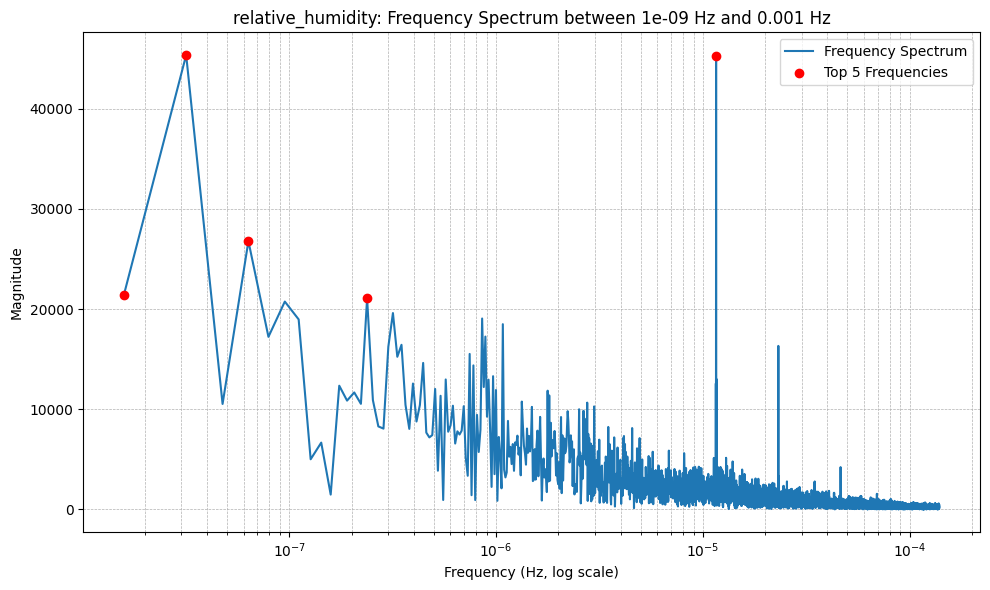

Top 5 frequencies with highest magnitude:
Frequency: 0.00002315 Hz, Period: 12.00 hours, Magnitude: 7197.0070
Frequency: 0.00000016 Hz, Period: 1754.40 hours, Magnitude: 7327.8943
Frequency: 0.00000032 Hz, Period: 877.20 hours, Magnitude: 7978.7777
Frequency: 0.00000006 Hz, Period: 4386.00 hours, Magnitude: 12581.6829
Frequency: 0.00000003 Hz, Period: 8772.00 hours, Magnitude: 17721.5687


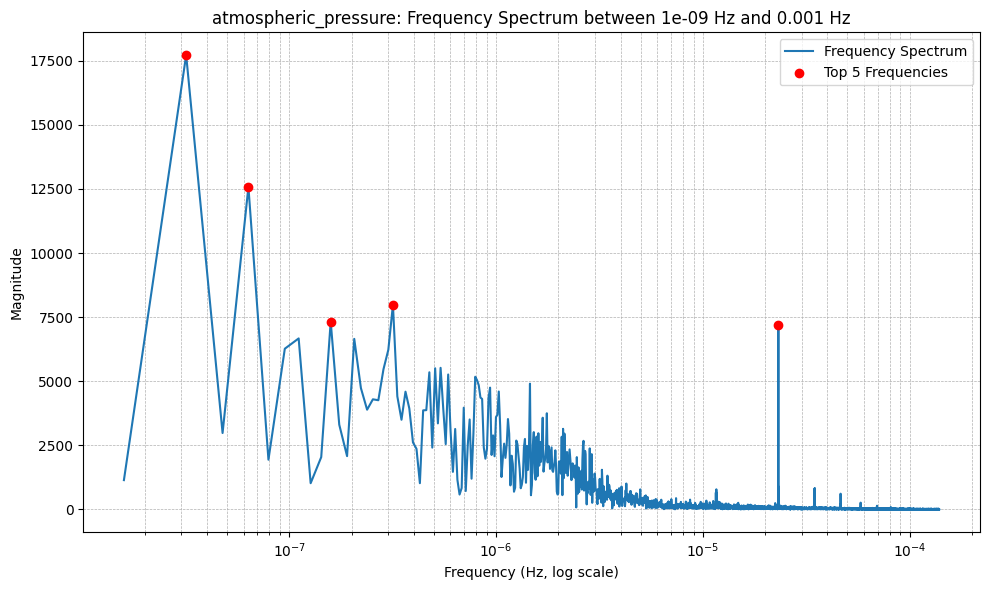

Plotting frequencies for openmeteo_punta_hidalgo...
Top 5 frequencies with highest magnitude:
Frequency: 0.00000006 Hz, Period: 4386.00 hours, Magnitude: 4924.4384
Frequency: 0.00000002 Hz, Period: 17544.00 hours, Magnitude: 5437.7765
Frequency: 0.00002315 Hz, Period: 12.00 hours, Magnitude: 8288.7357
Frequency: 0.00001157 Hz, Period: 24.00 hours, Magnitude: 22255.9964
Frequency: 0.00000003 Hz, Period: 8772.00 hours, Magnitude: 24508.2875


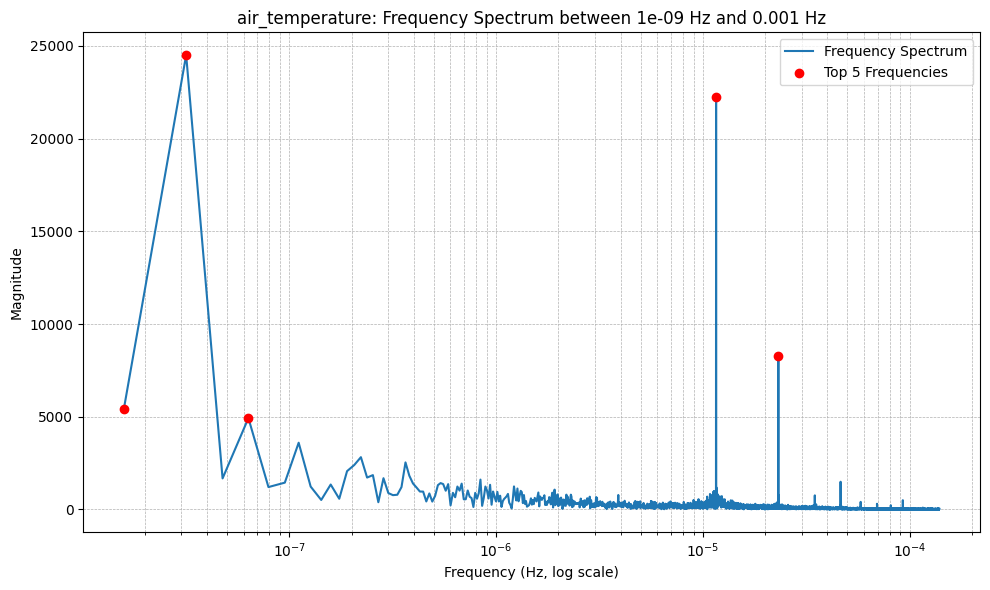

Top 5 frequencies with highest magnitude:
Frequency: 0.00000030 Hz, Period: 923.37 hours, Magnitude: 13970.3128
Frequency: 0.00000074 Hz, Period: 373.28 hours, Magnitude: 15157.4232
Frequency: 0.00000006 Hz, Period: 4386.00 hours, Magnitude: 19537.3097
Frequency: 0.00002315 Hz, Period: 12.00 hours, Magnitude: 36602.1447
Frequency: 0.00001157 Hz, Period: 24.00 hours, Magnitude: 114450.1824


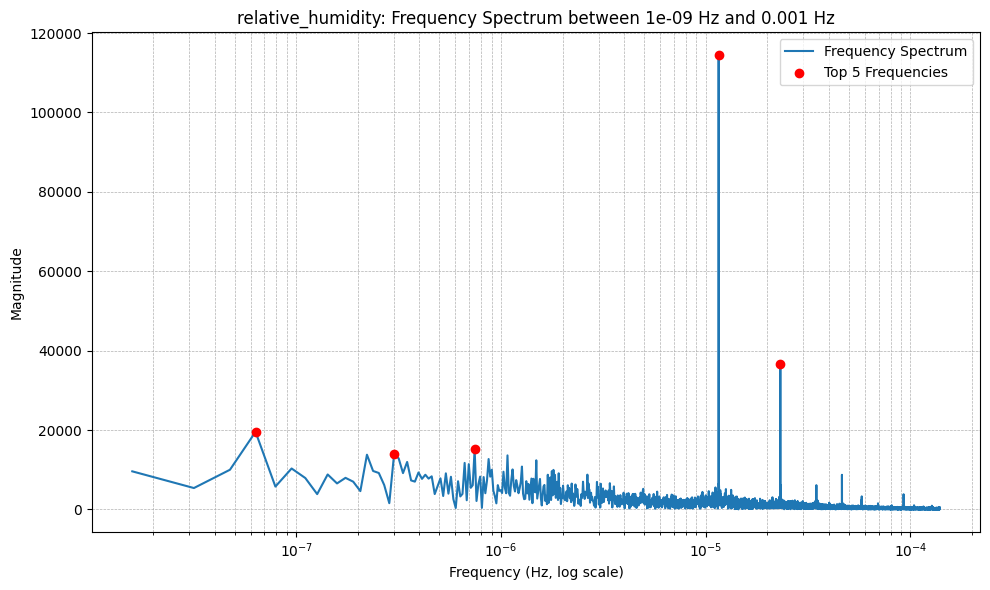

Top 5 frequencies with highest magnitude:
Frequency: 0.00000016 Hz, Period: 1754.40 hours, Magnitude: 7337.6330
Frequency: 0.00002315 Hz, Period: 12.00 hours, Magnitude: 7424.7664
Frequency: 0.00000032 Hz, Period: 877.20 hours, Magnitude: 8064.1350
Frequency: 0.00000006 Hz, Period: 4386.00 hours, Magnitude: 12390.2930
Frequency: 0.00000003 Hz, Period: 8772.00 hours, Magnitude: 20755.9441


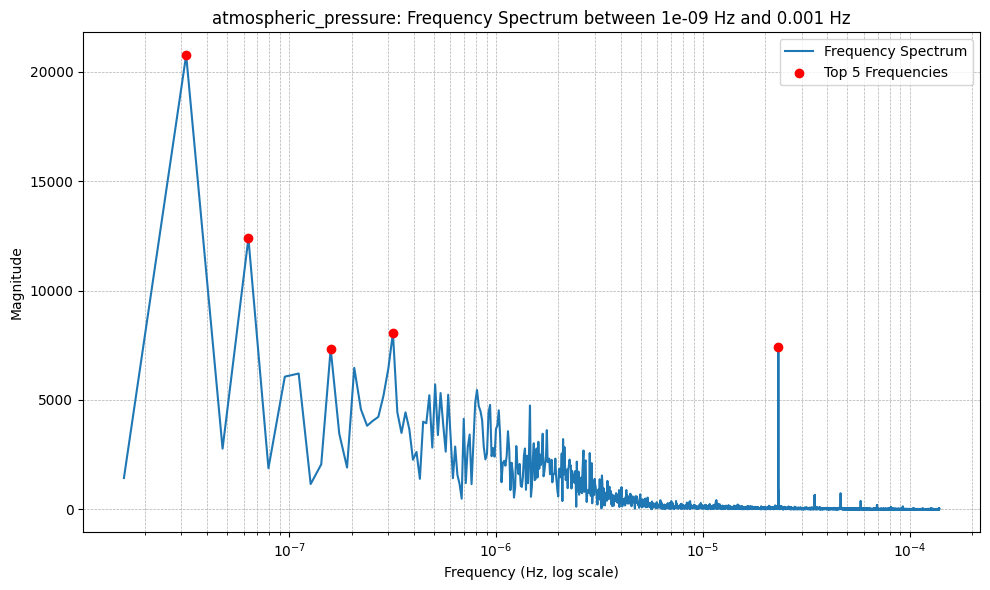

In [151]:
min_frequency = 10**-9
max_frequency = 10**-3
top_n = 5

for name, df in dataframes.items():
  print(f"Plotting frequencies for {name}...")
  plot_frequencies(df, "air_temperature", min_frequency, max_frequency, top_n)
  plot_frequencies(df, "relative_humidity", min_frequency, max_frequency, top_n)
  plot_frequencies(df, "atmospheric_pressure", min_frequency, max_frequency, top_n)

## Adición datos temporales

In [152]:
def add_time_features(df): 
    # Extract hour and minute to get a more continuous representation of time within a day
    df.index.name = "time"
    df.reset_index(inplace=True)

    df['time'] = pd.to_datetime(df['time'])
    hours = df['time'].dt.hour
    minutes  = df['time'].dt.minute
    hour_fraction = hours + minutes / 60.0

    # Convert the hour fraction into sine and cosine features to capture cyclical patterns (period = 24 hours)
    df['sin_day'] = np.sin(2 * np.pi * hour_fraction / 24)
    df['cos_day'] = np.cos(2 * np.pi * hour_fraction / 24)

    # Extract day of the week (0 = Monday, 6 = Sunday)
    day_of_week = df['time'].dt.weekday
    week_fraction = day_of_week + hour_fraction / 24.0  

    df['sin_week'] = np.sin(2 * np.pi * week_fraction / 7)
    df['cos_week'] = np.cos(2 * np.pi * week_fraction / 7)

    # For annual features: extract the day of the year (1-366)
    day_of_year = df['time'].dt.dayofyear

    # Subtracting 1 from day_of_year makes it start at 0, then add the fractional day.
    year_fraction = (day_of_year - 1) + hour_fraction / 24.0

    def is_leap_year(year):
        return (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0)
    
    # Apply the leap year function and store the result
    df['leap_year'] = df['time'].dt.year.apply(is_leap_year)

    df['sin_year'] = np.sin(2 * np.pi * year_fraction / (365 + df['leap_year']))
    df['cos_year'] = np.cos(2 * np.pi * year_fraction / (365 + df['leap_year']))

    # Drop the aux leap year variable
    df.drop(columns="leap_year", inplace=True)
                            
    # Remove original time variable
    #df.drop(columns="time", inplace=True)
    
for df in dataframes.values():
    add_time_features(df)


Plotting correlations for grafcan_punta_hidalgo...


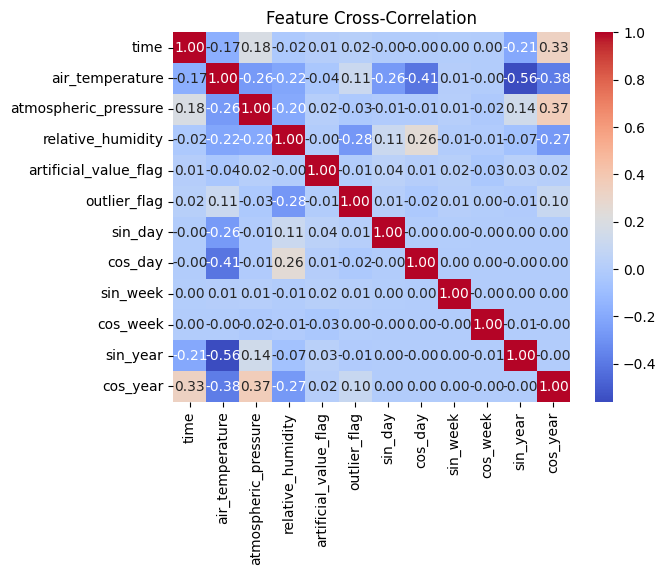

Plotting correlations for openmeteo_punta_hidalgo...


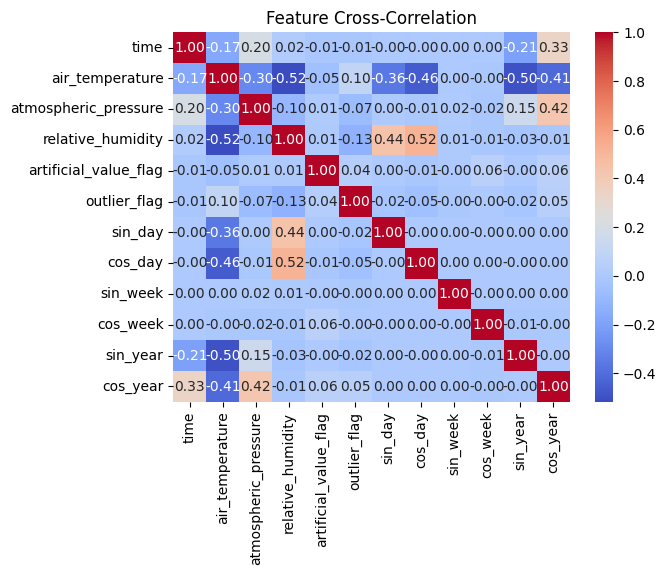

In [153]:
for name, df in dataframes.items():
  print (f"Plotting correlations for {name}...")
  
  correlation_matrix = df.corr()

  # Heatmap for visualization
  sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
  plt.title("Feature Cross-Correlation")
  plt.show()


In [154]:
for df in dataframes.values():
  df.drop(columns=["sin_week", "cos_week"], inplace=True)

## Escritura fichero 

In [155]:
for name, df in dataframes.items():
  df.to_csv("processed_data/" + name + "_features.csv", index=False)